# Моделирование распределения доходностей финансовых активов и оценка опционов

Написание алгоритма моделирования доходностей финансовых активов и оценки опционов начинаем с импорта библиотек

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
import scipy.optimize as spop # Необходим для численной оптимизации при использовании метода максимального правдоподобия
import matplotlib.pyplot as plt
import datetime
import random

Здесь появлялась ошибка синтаксиса, которая лечилась добавлением двойной косой черты "\\"

In [2]:
# Экспортируем котировки фьючерса на индекс РТС. Данные взяты отсюда: https://www.finam.ru/profile/mosbirzha-fyuchersy/rts/export/
raw_data = pd.read_csv('E:\\repo\\valuation_of_options\\rts_9-23\\SiZ3_04-10-2023.csv')
raw_data.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SiZ3 [SPBFUT],Daily,20211213,0,85455.0,85766.0,85455.0,85600.0,9.0
1,SiZ3 [SPBFUT],Daily,20211214,0,85250.0,85250.0,85250.0,85250.0,1.0
2,SiZ3 [SPBFUT],Daily,20211215,0,86000.0,86370.0,86000.0,86110.0,6.0
3,SiZ3 [SPBFUT],Daily,20211217,0,86390.0,86690.0,86390.0,86393.0,6.0
4,SiZ3 [SPBFUT],Daily,20211220,0,86607.0,86658.0,86598.0,86658.0,6.0


In [3]:
# Получаем общие сведения о датасете
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <TICKER>  455 non-null    object 
 1   <PER>     455 non-null    object 
 2   <DATE>    455 non-null    int64  
 3   <TIME>    455 non-null    int64  
 4   <OPEN>    455 non-null    float64
 5   <HIGH>    455 non-null    float64
 6   <LOW>     455 non-null    float64
 7   <CLOSE>   455 non-null    float64
 8   <VOL>     455 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 32.1+ KB


In [4]:
# Здесь мне надо было убедиться, что данные являются датафреймом
type(raw_data)

pandas.core.frame.DataFrame

In [5]:
# Доходность получаем следующим образом
raw_data['return'] = (raw_data['<CLOSE>'] - raw_data['<OPEN>']) / raw_data['<OPEN>']
raw_data['return'].head()

0    0.001697
1    0.000000
2    0.001279
3    0.000035
4    0.000589
Name: return, dtype: float64

In [6]:
# ранжируем наблюдения от меньших к большим и вычислим эмпирическую функцию распределения
raw_data['rank'] = (raw_data['return'].rank(method='first'))/(len(raw_data))
raw_data = raw_data.sort_values(by='rank').reset_index(drop=True)

In [7]:
# Вычислим наиболее важные описательные статистики эмпирического распределения
mean = np.average(raw_data['return']) # средняя доходность
med = np.median(raw_data['return']) # медианная доходность
std = np.std(raw_data['return']) # Стандартное отклонение
var = std**2 # Дисперсия
skew = sps.skew(raw_data['return']) # Скошенность
kurt = sps.kurtosis(raw_data['return']) # Эксцесс

**Среднее абсолютное отклонение**, или просто **среднее отклонение** (англ. MAD, mean absolute deviation) - величина, используемая для оценки прогнозных функций:

$MAD=\frac{1}{n}\displaystyle\sum_{i=1}^{n} |{x}_{i}-m(X)|$


In [8]:
# Оценим параметры распределения Лапласа методом максимального правдоподобия
loc_laplace = med # параметр локации Лапласа это просто медиана
scale_laplace = np.average(abs(raw_data['return'] - med)) # Параметр масштаба Лапласа - это среднее абсолютное отклонение

In [9]:
# Оценим параметры распределения Коши методом моментов
loc_cauchy = med
scale_cauchy = (np.percentile(raw_data['return'], 0.75) - np.percentile(raw_data['return'], 0.25))/2

In [10]:
# Оценим параметры распределения Koши методом максимального правдоподобия
def cauchy_mle(k):
    return -np.sum(np.log(1/(np.pi*k[1]*(1 + ((raw_data['return'] - k[0])/k[1])**2))))
res = spop.minimize(cauchy_mle, [loc_cauchy, scale_cauchy], method='Powell')
loc_cauchy_mle = res.x[0]
scale_cauchy_mle = res.x[1]

e:\repo\valuation_of_options\virtenv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# Оценим параметры гипреболического секанта методом максимального правдоподобия
def hypersecant_mle(k):
    return -np.sum(np.log(np.pi/k[1])*np.exp(np.pi/2*(raw_data['return'] - k[0])/k[1])/(1 + np.exp(np.pi * (raw_data['return'] - k[0])/k[1])))
res = spop.minimize(hypersecant_mle, [mean, std], method='Powell')
loc_hypersecant_mle = res.x[0]
scale_hypersecant_mle = res.x[1]

C:\Users\Pro\AppData\Local\Temp\ipykernel_19924\998792672.py:3: RuntimeWarning: invalid value encountered in log
  return -np.sum(np.log(np.pi/k[1])*np.exp(np.pi/2*(raw_data['return'] - k[0])/k[1])/(1 + np.exp(np.pi * (raw_data['return'] - k[0])/k[1])))


In [12]:
# Оценим параметры логистического распределения методом моментов
loc_logistic = mean
scale_logistic = 3**(1/2)/np.pi*std

In [13]:
# Оценим параметры логистического распределения методом максимального правдоподобия
def logistic_mle(k):
    return -np.sum(np.log(np.exp(-(raw_data['return'] - k[0])/k[1])/(k[1]*(1+np.exp(-(raw_data['return'] - k[0])/k[1]))**2)))
res = spop.minimize(logistic_mle, [loc_logistic, scale_logistic], method='Powell')
loc_logistic_mle = res.x[0]
scale_logistic_mle = res.x[1]

In [14]:
# Оценим параметры распределения Стьюдента методом моментов
df_student = 6/kurt + 4
loc_student = mean
scale_student = std*((df_student - 2)/df_student)**(1/2)

##### Распределение Лапласа (двойное экспоненциальное, двойное показательное)
Функция распределения:

$F(x) = \begin{cases}\frac{1}{2}e^{(\frac{x-m}{b})}, x \leq m\\1-\frac{1}{2}e^{-\frac{x-m}{b}}, x > m\end{cases}$

где $x$ - доходность

$m$ - медианная доходность

$b$ - среднее абсолютное отклонение

Функция плотности вероятности:

$f(x)=\frac{1}{2b}e^{-\frac{|x-m|}{b}}$

Эксцесс = 3

Оценка параметров методом максимального правдоподобия (ММП): медиана и среднее абсолютное отклонение

In [15]:
# Выведем теоретические функции распределения исходя из оценённых параметров
raw_data['Нормальное'] = sps.norm.cdf(raw_data['return'], loc=mean, scale=std)
raw_data['Коши-ММ'] = 1/np.pi*np.arctan((raw_data['return'] - loc_cauchy)/scale_cauchy) + 1/2
raw_data['Коши-ММП'] = 1/np.pi*np.arctan((raw_data['return'] - loc_cauchy_mle)/scale_cauchy_mle) + 1/2
raw_data['Лаплас1'] = 1/2 * np.exp((raw_data[raw_data['return']<=loc_laplace]['return']-med)/scale_laplace)
raw_data['Лаплас2'] = 1-1/2*np.exp(-(raw_data[raw_data['return']>med]['return']-loc_laplace)/scale_laplace)
raw_data['Лаплас'] = raw_data['Лаплас1'].replace(np.nan, 0) + raw_data['Лаплас2'].replace(np.nan, 0)
raw_data['Гиперсекант-ММ'] = 2/np.pi*np.arctan(np.exp(np.pi*(raw_data['return']-mean)/(2*std)))
raw_data['Гиперсекант-ММП'] = 2/np.pi*np.arctan(np.exp(np.pi*(raw_data['return']-loc_hypersecant_mle)/(2*scale_hypersecant_mle)))
raw_data['Стьюдент'] = sps.t.cdf((raw_data['return']-loc_student)/(scale_student), df_student, loc=0, scale=1)
raw_data['Логистическое-ММ'] = 1/(1+np.exp(-(raw_data['return']-loc_logistic)/scale_logistic))
raw_data['Логистическое-ММП'] = 1/(1+np.exp(-(raw_data['return']-loc_logistic_mle)/scale_logistic_mle))


Нормальное

Супремум равен: 0.1142
p-значение равно: 0.0027
Распределение не подходит


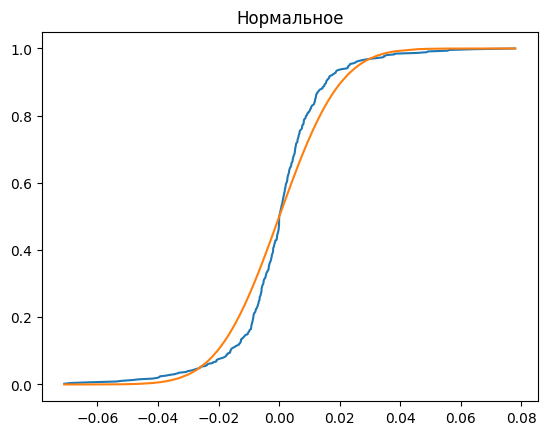


Лаплас

Супремум равен: 0.0413
p-значение равно: 0.4609
Распределение подходит


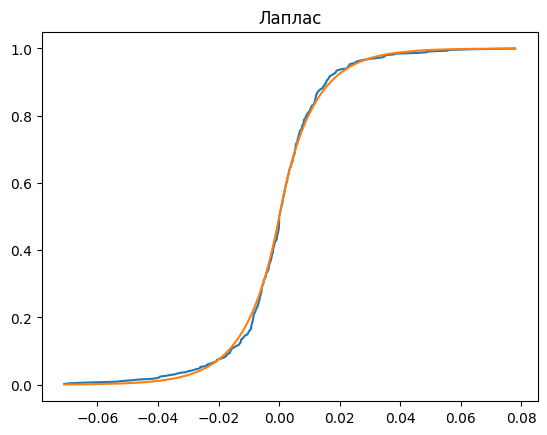


Гиперсекант-ММ

Супремум равен: 0.0766
p-значение равно: 0.0694
Распределение не подходит


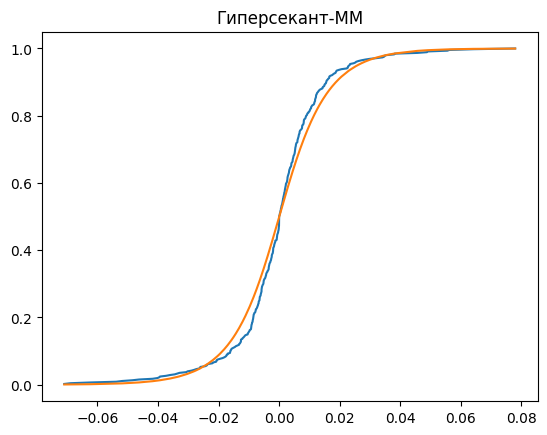


Гиперсекант-ММП

Супремум равен: 0.182
p-значение равно: 0.0
Распределение не подходит


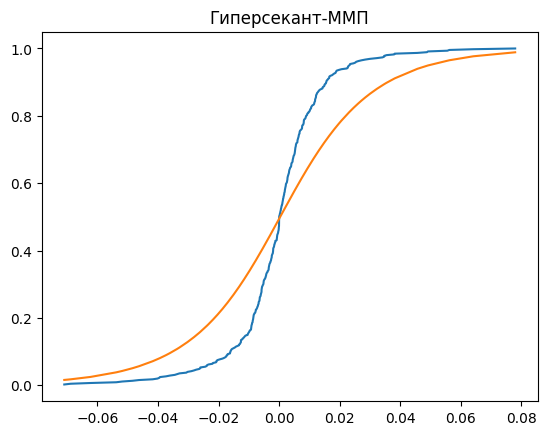


Коши-ММ

Супремум равен: 0.0536
p-значение равно: 0.27
Распределение подходит


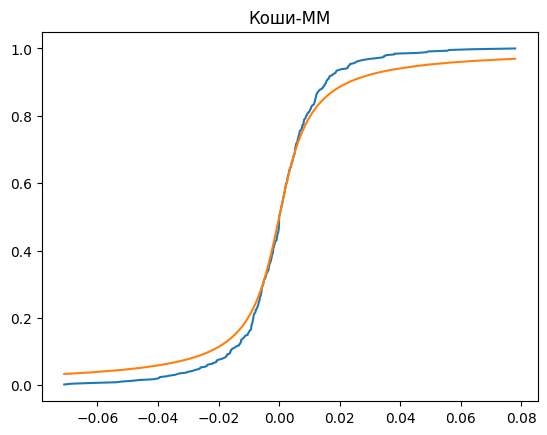


Коши-ММП

Супремум равен: 0.0396
p-значение равно: 0.4891
Распределение подходит


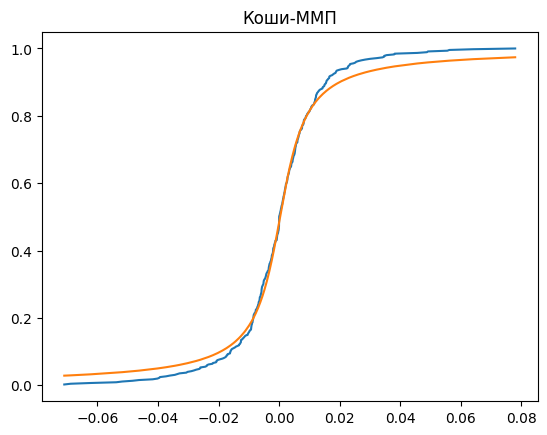


Стьюдент

Супремум равен: 0.0798
p-значение равно: 0.055
Распределение не подходит


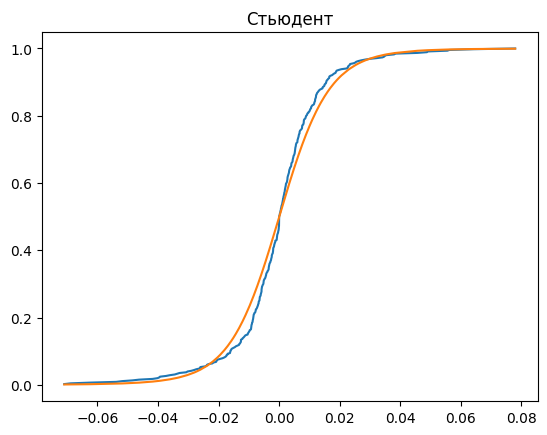


Логистическое-ММ

Супремум равен: 0.092
p-значение равно: 0.0212
Распределение не подходит


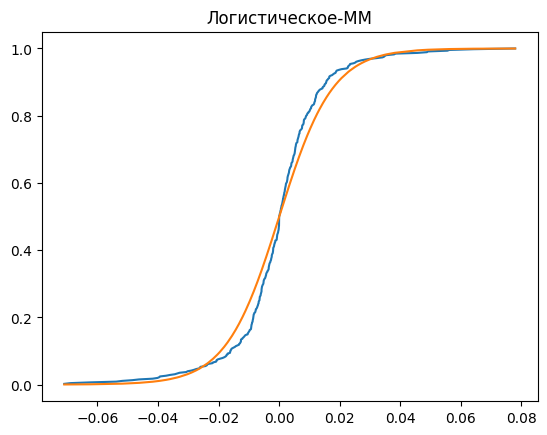


Логистическое-ММП

Супремум равен: 0.0624
p-значение равно: 0.1704
Распределение подходит


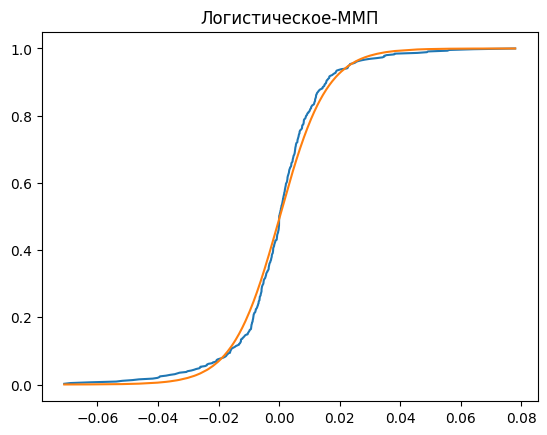

In [16]:
# Сравним теоретические функции распределения с эмпирическими для каждого распределения
distributions = [
	"Нормальное",
	"Лаплас",
	"Гиперсекант-ММ",
	"Гиперсекант-ММП",
	"Коши-ММ",
	"Коши-ММП",
	"Стьюдент",
	"Логистическое-ММ",
	"Логистическое-ММП",
]
for dist in distributions:
	
	# Вычислим супремум (статистику Колмогорова-Смирнова)
	KS_array = abs(raw_data["rank"] - raw_data[dist])
	KS = max(KS_array)
	
	# вычислим р-значения (вероятность, с которой данные подчиняются этому распределению)
	KS_p = np.exp(-(KS**2) * len(raw_data))
	
	# визуализируем результат и выведем результаты теста Колмогорова-Смирнова
	print()
	print(dist)
	print()
	print('Супремум равен: ' + str(round(KS, 4)))
	print('p-значение равно: ' + str(round(KS_p, 4)))
	
	if KS_p > 0.1:
		print('Распределение подходит')
	else:
		print('Распределение не подходит')
	plt.figure(dist)
	plt.plot(raw_data['return'], raw_data['rank'])
	plt.plot(raw_data['return'], raw_data[dist])
	plt.title(dist)
	plt.show()

In [17]:
# Введем характеристики стратегии

start_price = 99678.0 # стартовая цена
start_dt = datetime.date(2023, 10, 4) # стартовая дата
end_dt = datetime.date(2023, 10, 5) # дата экспирации
expiry = (end_dt - start_dt).days # число дней от начала торгов до даты экспирации
maturity = expiry/365 # срочность
t_days = int(maturity*252) # сколько торговых дней между началом стратегии и экспирацией
strike = 99500.0 # цена страйк
call_bid = 1032.0 # 
call_ask = 1219.0 #
put_bid = 911.0 #
put_ask = 1036.0 #
end_price = 99678.0 #

drift = (1+mean)**252-1 # годовая ожидаемая доходность
vol = std*(252)**(1/2) #

In [18]:
# определим функцию симуляции опционной стратегии
def strategy_simulation(k):
    payoff = 0
    print()
    print('Справедливая стоимость опциона колл равна ' + str(round(k[0], 4)))
    if k[0] > call_ask:
        print('Используем стратегию лонг колл')
        payoff += max(0, end_price - strike) - call_ask
    elif k[0] < call_bid:
        print('Используем стратегию шорт колл')
        payoff += call_bid - max(0, end_price - strike)
    else:
        print('Стратегии на основе опциона call невыгдны')
    print()
    print('Справедливая стоимость опциона put равна ' + str(round(k[1], 4)))
    if k[1] > put_ask:
        print('Используем стратегию long put')
        payoff += max(0, strike - end_price) - put_ask
    elif k[1] < put_bid:
        print('Используем стратегию short put')
        payoff += put_bid - max(0, strike - end_price)
    else:
        print('Стратегии на основе опциона put невыгодны')
    print()
    if payoff >= 0:
        print('Вы заработали ' + str(round(payoff, 4)) + ' долларов на акцию')
    else:
        print('Вы потеряли ' + str(round(abs(payoff), 4)) + ' долларов на акцию')
    print()

In [19]:
# Оценим опционы с помощью модели Блэка-Шоулза
d1 = (np.log(start_price/strike)+(drift+vol**2/2)*maturity)/(vol*maturity**(1/2))
d2 = (np.log(start_price/strike)+(drift-vol**2/2)*maturity)/(vol*maturity**(1/2))

In [20]:
# Нормальное распределение

call_value = start_price*sps.norm.cdf(d1, loc=0, scale=1) - strike*np.exp(-drift*maturity)*sps.norm.cdf(d2, loc=0, scale=1)
put_value = -start_price*sps.norm.cdf(-d1, loc=0, scale=1) + strike*np.exp(-drift*maturity)*sps.norm.cdf(-d2, loc=0, scale=1)

print()
print('Блэк-Шоулз, нормальное распрелеление')
strategy_simulation([call_value, put_value])


Блэк-Шоулз, нормальное распрелеление

Справедливая стоимость опциона колл равна 623.1529
Используем стратегию шорт колл

Справедливая стоимость опциона put равна 440.6891
Используем стратегию short put

Вы заработали 1765.0 долларов на акцию



In [21]:
# Оценим опционы с помощью метода Монте-Карло

# Нормальное распределение

# Симулируем 1000 сценариев
n_simulations = 1000
call_payoff = 0
put_payoff = 0
for i in range(0, n_simulations):
	price = start_price
	# Симулируем движение акции на протяжении всех торговых дней вплоть до экспирации
	for t in range(0, t_days):
		prob = random.randrange(1, 99, 1)/100
		simulated = sps.norm.ppf(prob, loc=mean, scale=std)
		price = price*np.exp(simulated)
	call_payoff += max(0, price - strike)
	put_payoff += max(0, strike - price)
# Ценность опциона - ожидаемый выигрыш
call_value = call_payoff/n_simulations
put_value = put_payoff/n_simulations

print()
print('Монте-Карло, нормальное распределение')
strategy_simulation([call_value, put_value])


Монте-Карло, нормальное распределение

Справедливая стоимость опциона колл равна 178.0
Используем стратегию шорт колл

Справедливая стоимость опциона put равна 0.0
Используем стратегию short put

Вы заработали 1765.0 долларов на акцию



In [22]:
# Стьюдент

n_simulations = 1000
call_payoff = 0
put_payoff = 0
for i in range(0, n_simulations):
	price = start_price
	for t in range(0, t_days):
		prob = random.randrange(1, 99, 1)/100
		simulated = mean + std*sps.t.ppf(prob, df_student)
		price = price*np.exp(simulated)
	call_payoff += max(0, price - strike)
	put_payoff += max(0, strike - price)
call_value = call_payoff/n_simulations
put_value = put_payoff/n_simulations

print()
print('Монте-Карло, распределение Стьюдента')
strategy_simulation([call_value, put_value])


Монте-Карло, распределение Стьюдента

Справедливая стоимость опциона колл равна 178.0
Используем стратегию шорт колл

Справедливая стоимость опциона put равна 0.0
Используем стратегию short put

Вы заработали 1765.0 долларов на акцию



In [23]:
# Коши

n_simulations = 1000
call_payoff = 0
put_payoff = 0
for i in range(0, n_simulations):
	price = start_price
	for t in range(0, t_days):
		prob = random.randrange(1, 99, 1)/100
		simulated = loc_cauchy_mle + scale_cauchy_mle*np.tan(np.pi*prob - np.pi/2)
		price = price*np.exp(simulated)
	call_payoff += max(0, price - strike)
	put_payoff += max(0, strike - price)
call_value = call_payoff/n_simulations
put_value = put_payoff/n_simulations

print()
print('Монте-Карло, распределение Коши')
strategy_simulation([call_value, put_value])


Монте-Карло, распределение Коши

Справедливая стоимость опциона колл равна 178.0
Используем стратегию шорт колл

Справедливая стоимость опциона put равна 0.0
Используем стратегию short put

Вы заработали 1765.0 долларов на акцию



In [24]:
# Лаплас
# Симулируем 1000 сценариев
n_simulations = 1000
call_payoff = 0
put_payoff = 0
for i in range(0, n_simulations):
	price = start_price
	# Симулируем движение акции на протяжении всех торговых дней вплоть до экспирации
	for t in range(0, t_days):
		prob = random.randrange(1, 99, 1)/100
		simulated = sps.laplace.ppf(prob, loc=mean, scale=std)
		price = price*np.exp(simulated)
	call_payoff += max(0, price - strike)
	put_payoff += max(0, strike - price)
# Ценность опциона - ожидаемый выигрыш
call_value = call_payoff/n_simulations
put_value = put_payoff/n_simulations

print()
print('Монте-Карло, распределение Лапласа')
strategy_simulation([call_value, put_value])


Монте-Карло, распределение Лапласа

Справедливая стоимость опциона колл равна 178.0
Используем стратегию шорт колл

Справедливая стоимость опциона put равна 0.0
Используем стратегию short put

Вы заработали 1765.0 долларов на акцию

